# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Class')

Mounted at /content/drive


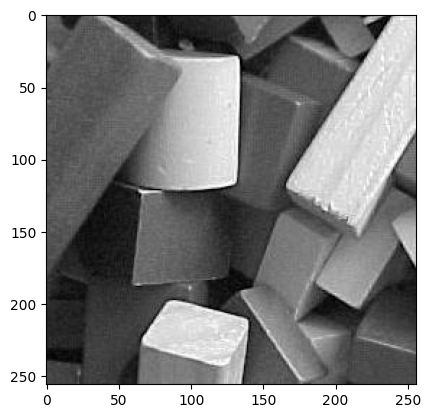

image.shape:  (256, 256)


In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("blocks.jpg",0)
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)


## Step 1. Gaussian filter

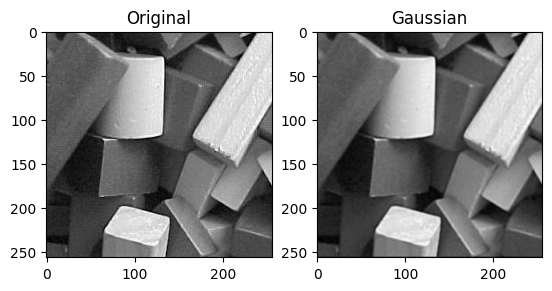

Original shape (256, 256)
Gaussian shape (256, 256)


In [ ]:
def padding_img(img,k_size,style='edge'):
  # ------------ To do ------------- #
  h, w = img.shape
  ph, pw = k_size, k_size
  padded_image = np.zeros((h + ph*2, w + pw*2), dtype=img.dtype)
  padded_image[ph:h+ph, pw:w+pw] = img
  return padded_image

def gaussian_kernel(size):
  # ------------ To do ------------- #
  sigma = 0.3*((size-1)*0.5 - 1) + 0.8
  kernel = np.zeros((size, size))
  center = size // 2
  total=0
  for i in range(size):
      for j in range(size):
          x = i - center
          y = j - center
          kernel[i, j] = math.exp(-(x**2 + y**2) / (2 * sigma**2))
          kernel[i, j] /= 2 * math.pi * sigma**2
          total = total + kernel[i, j]
  return kernel


KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row,col = image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    # ------------ To do ------------- #
    padding_siz = (KernelSize-1)//2   
    for i in range(padding_siz, padimg.shape[0]-padding_siz): # loop over the rows
        for j in range(padding_siz, padimg.shape[1]-padding_siz): # loop over the columns
            resx[i-padding_siz, j-padding_siz] = np.sum(padimg[i-padding_siz : i+padding_siz+1, j-padding_siz : j+padding_siz+1] * Gaussian_Kernel)
    return resx

gaussian = Gaussian_Filter(KernelSize,img_org)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(img_org.astype('uint8'), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(gaussian.astype('uint8'), cmap='gray')
axes[1].set_title('Gaussian')
plt.show()

print("Original shape",img_org.shape)
print("Gaussian shape",gaussian.shape)

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [ ]:
from scipy.ndimage import convolve

def sobel(img):
    #h, w = img.shape
    img = cv2.GaussianBlur(img, (5, 5), 0)
    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
    # ------------ To do ------------- #
    Gx = cv2.filter2D(img, -1, horizontal)
    Gy = cv2.filter2D(img, -1, vertical)
    # gradient magnitude and direction
    amplitude = np.sqrt(Gx.astype(np.uint16)**2 + Gy.astype(np.uint16)**2)
    amplitude = amplitude.astype(np.uint8)
    angle = np.arctan2(Gy, Gx) * 180 / np.pi
    
    return Gx, Gy, amplitude, angle


def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j



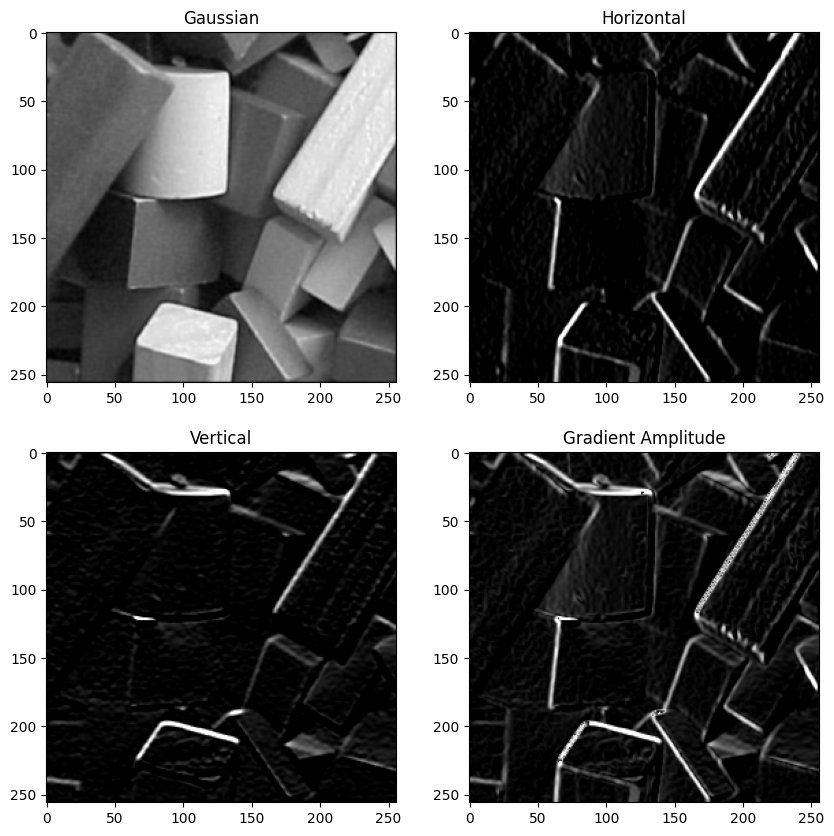

In [ ]:
# ------------ To do ------------- #

hor, ver, amp, angle = sobel(img_org)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
axes[0,0].imshow(gaussian.astype('uint8'), cmap='gray')
axes[0,0].set_title('Gaussian')
axes[0,1].imshow(hor.astype('uint8'), cmap='gray')
axes[0,1].set_title('Horizontal')
axes[1,0].imshow(ver.astype('uint8'), cmap='gray')
axes[1,0].set_title('Vertical')
axes[1,1].imshow(amp.astype(np.uint8), cmap='gray')
axes[1,1].set_title('Gradient Amplitude')
plt.show()


## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [ ]:
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            # ------------ To do ------------- #
            q = 255
            r = 255

            # Determine which direction to compare
            if (0 <= angle[i - 1, j - 1] < 22.5) or (157.5 <= angle[i - 1, j - 1] <= 180):
              q = gradient[i, j + 1]
              r = gradient[i, j - 1]
            elif 22.5 <= angle[i - 1, j - 1] < 67.5:
              q = gradient[i + 1, j - 1]
              r = gradient[i - 1, j + 1]
            elif 67.5 <= angle[i - 1, j - 1] < 112.5:
              q = gradient[i + 1, j]
              r = gradient[i - 1, j]
            elif 112.5 <= angle[i - 1, j - 1] < 157.5:
              q = gradient[i - 1, j - 1]
              r = gradient[i + 1, j + 1]

            # Compare the pixel value with its neighbors
            if (gradient[i - 1, j - 1] >= q) and (gradient[i - 1, j - 1] >= r):
              gradient_copy[i, j] = gradient[i - 1, j - 1]
            else:
              gradient_copy[i, j] = 0
      
    return gradient_copy

hor, ver, gradient, angle = sobel(img_org)
After_non_maximum_supression = non_maximum_suppression(gradient,angle)
print(After_non_maximum_supression)


[[ 0  2  0 ... 12  8  0]
 [ 0  0  0 ...  0  0  4]
 [ 0  0  0 ...  0 13  2]
 ...
 [10  0  0 ...  4  4  0]
 [ 8 10  7 ...  0  0  0]
 [ 0  0  0 ...  2  6  0]]


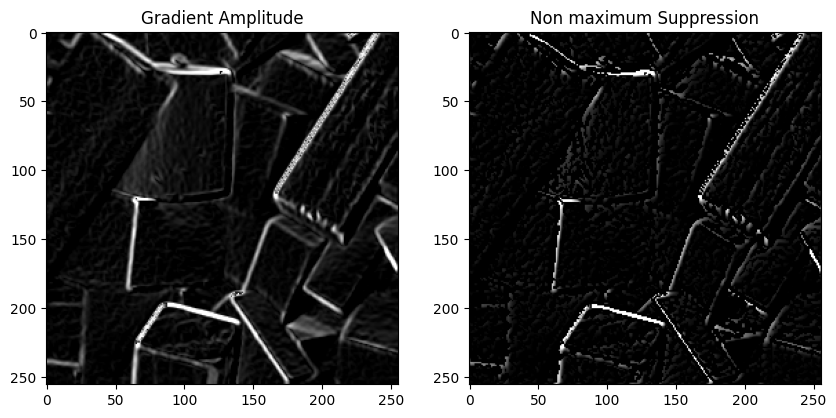

In [ ]:
# ------------ To do ------------- #

hor, ver, amp, angle = sobel(img_org)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,10))
axes[0].imshow(amp.astype(np.uint8), cmap='gray')
axes[0].set_title('Gradient Amplitude')
axes[1].imshow(After_non_maximum_supression.astype(np.uint8), cmap='gray')
axes[1].set_title('Non maximum Suppression')
plt.show()


## Step 4. Thresholding edges

In [ ]:
def seperate(img, minimum = 60, maximum = 180):
    # ------------ To do ------------- #
    height, width = img.shape[:2]
    thresh = img.copy()
    for y in range(height):
      for x in range(width):
        if img[y][x] < minimum :
          thresh[y][x] = 0
        elif( minimum <= img[y][x] < maximum):
          thresh[y][x] = 20
        else:
          thresh[y][x] = 255
    return thresh
    


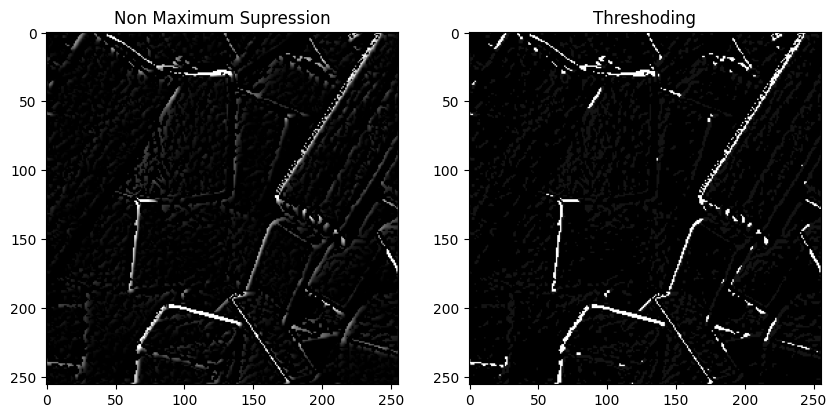

In [ ]:
# ------------ To do ------------- #
thresholding = seperate(After_non_maximum_supression, minimum = 15, maximum = 90)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,10))
axes[0].imshow(After_non_maximum_supression.astype(np.uint8), cmap='gray')
axes[0].set_title('Non Maximum Supression')
axes[1].imshow(thresholding.astype(np.uint8), cmap='gray')
axes[1].set_title('Threshoding')
plt.show()

## Step 5. Hysteresis

In [ ]:
def Connect(img,weak=60):
  # ------------ To do ------------- #

  strong_edges = (img == 255)
  weak_edges = (img == weak)
  output = np.zeros(img.shape, dtype=np.uint8)
  output[strong_edges] = 255

  row, col = np.nonzero(weak_edges)
  for r, c in zip(row, col):
    if np.any(strong_edges[r-1:r+2, c-1:c+2]):
        output[r, c] = 255       
  return output

dst_img = Connect(thresholding,20)


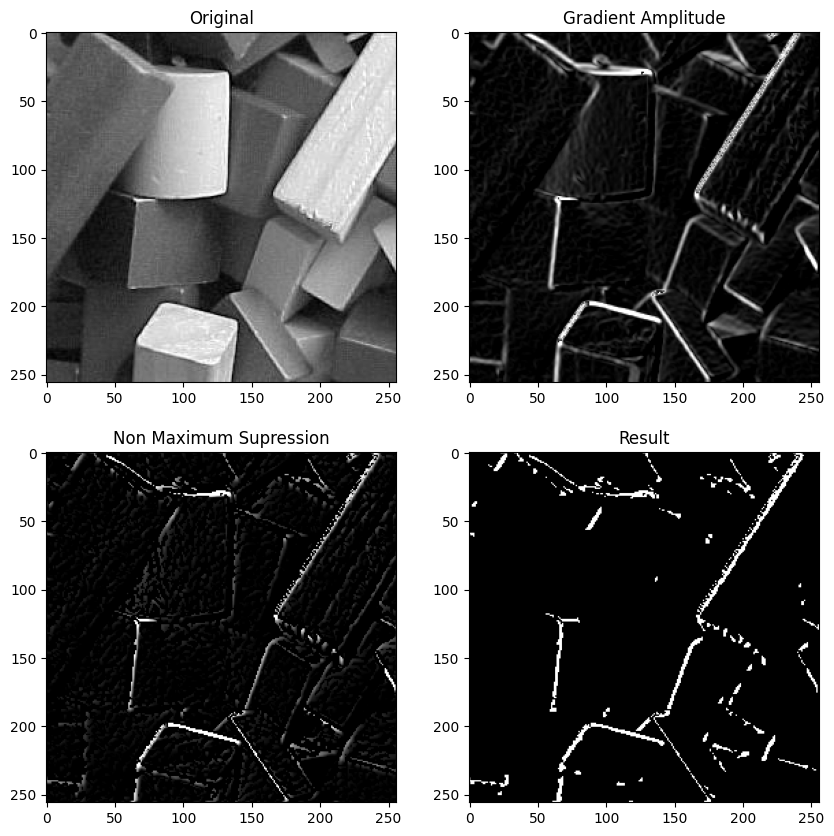

In [ ]:
# ------------ To do ------------- #
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
axes[0,0].imshow(img_org.astype('uint8'), cmap='gray')
axes[0,0].set_title('Original')
axes[0,1].imshow(amp.astype(np.uint8), cmap='gray')
axes[0,1].set_title('Gradient Amplitude')
axes[1,0].imshow(After_non_maximum_supression.astype('uint8'), cmap='gray')
axes[1,0].set_title('Non Maximum Supression')
axes[1,1].imshow(dst_img.astype(np.uint8), cmap='gray')
axes[1,1].set_title('Result')
plt.show()

## Canny Edge OpenCV 套件


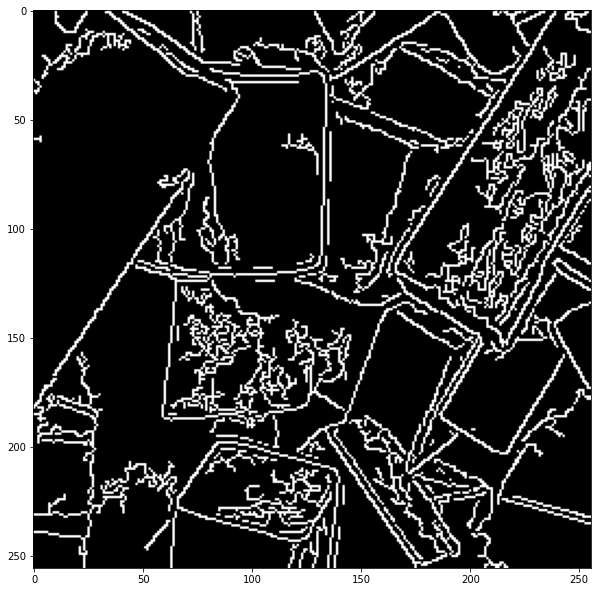

In [ ]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("blocks.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

## 加分討論：為什麼和套件不一樣？

因為...

# 加分題目 : Dilation (膨脹) & Erosion (侵蝕)

## Dilation (膨脹)

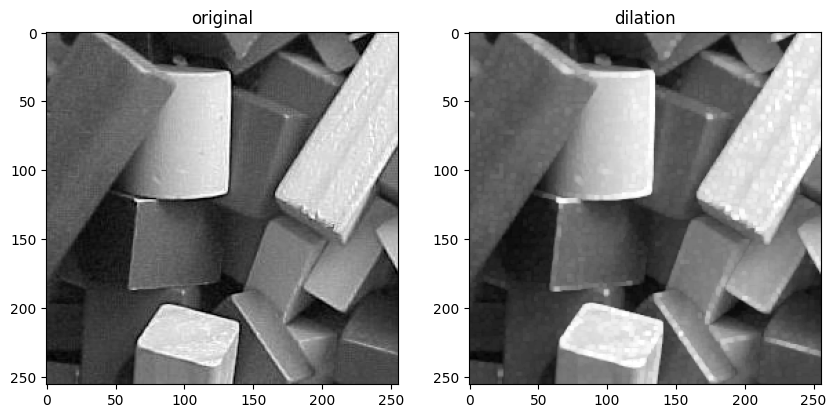

original shape:  (256, 256)
dilation shape:  (256, 256)


In [14]:
def Dilation(img):
  kernel = np.ones((3,3), np.uint8)
  padded_img = np.pad(img, ((1, 1), (1, 1)), mode='constant')

  dilation = np.zeros_like(img)
  for i in range(1, img.shape[0]+1):
    for j in range(1, img.shape[1]+1):
      dilation[i-1, j-1] = np.max(padded_img[i-1:i+2, j-1:j+2] * kernel)
  return dilation

img_org = cv2.imread("blocks.jpg",0)
res = Dilation(img_org)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(img_org, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('dilation')
plt.imshow(res.astype('uint8'), cmap = 'gray')
plt.show()

print('original shape: ', img_org.shape)
print('dilation shape: ', res.shape)

## Erosion (侵蝕)

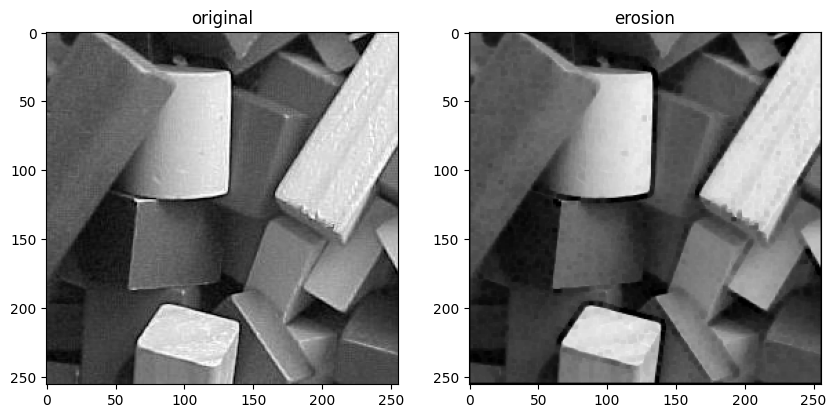

original shape:  (256, 256)
erosion shape:  (256, 256)


In [16]:
from matplotlib.colors import Image
def Erosion(img):
  # Define kernel
  kernel = np.ones((3,3), np.uint8)

  # Pad image with zeros
  padded_img = np.pad(img, ((1, 1), (1, 1)), mode='constant')

  # Perform erosion
  erosion = np.zeros_like(img)
  for i in range(1, img.shape[0]+1):
    for j in range(1, img.shape[1]+1):
      erosion[i-1, j-1] = np.min(padded_img[i-1:i+2, j-1:j+2] * kernel)
  return erosion

img_org = cv2.imread("blocks.jpg",0)
res = Erosion(img_org)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(img_org, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('erosion')
plt.imshow(res, cmap = 'gray')
plt.show()

print('original shape: ', img_org.shape)
print('erosion shape: ', res.shape)